Creating and validating a Neural Network to detect exons using two files containing several 51 nucleotides strings. One file contains real exon data from [#X], and the other file contains randomly generated exon data made to look similar to exons.

In [91]:
# Hard code for jupyter
file1 = "cds0.fa.gz" # true exons
file0 = "cdsf.fa.gz" # false 'randomly' generated sequences

Using Seqio script to read and convert fasta files into one hot encoded strings. Lables are created by appending 1 to real exon samples and 0 to false samples. Once labeled, the sequences are combined and read into a dataframe with one column per one hot encoded unit. Four units per nucleotide plus one unit for the label equals 205 columns: 4 * 51 + 1 = 205.

In [103]:
import seqio
import pandas as pd

# Convert true and false files into dataframe with labels, randomly shuffle
s1 = seqio.fasta2onehot(file1, '1')
s0 = seqio.fasta2onehot(file0, '0')
sequences = s1 + s0
# Turn each sequence into list of singular integers
sequences = [list(map(int, s)) for s in sequences]

df = pd.DataFrame(sequences)
df = df.sample(frac=1, random_state=42)

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
21391,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
18412,0,1,0,0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,0,1,0
3352,1,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,1
22130,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
15002,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,1,0,0,0,0,0,1,0,0,1,...,1,1,0,0,0,1,0,0,0,0
21575,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0
5390,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
860,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


Dataframe is then split into features and labels and split into training and testing data using sklearn's train_test_split function

In [93]:
from sklearn.model_selection import train_test_split

# Create training and test features and labels
features = df.iloc[:,:-1]
labels = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(features, labels,test_size=0.2)

The neural network is then compiled using the Keras sequential model. The model takes a 204 tensor input (doesn't include label). Then a 50 node hidden layer is added with dropout and regularization (?). Last, the model spits out a single node output 1 or 0 (exon or not).

This is then compiled using and Adam optimizer and learning rate of 0.0001. The model is compiled with accuracy, precision and recall metrics for later evaluation.

In [100]:
from tensorflow import keras

# Compile Neural Network
NN = keras.Sequential()

# Input Layer
NN.add(keras.layers.Dense(5, activation='sigmoid', input_shape=(x_train.shape[1],)))

#Hidden Layer
NN.add(keras.layers.Dense(50))
NN.add(keras.layers.Dropout(0.2))
NN.add(keras.layers.Dense(3, kernel_regularizer='l2'))

# Output layer
NN.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile
opt = keras.optimizers.Adam(learning_rate=0.0001)
my_metrics = ['accuracy', 
              keras.metrics.Precision(name='Precision',thresholds=0.5),
              keras.metrics.Recall(name='Recall',thresholds=0.5)]

NN.compile(loss='binary_crossentropy', optimizer=opt, metrics=my_metrics)

The Neural Network is then fitted with training features and labels. Epochs and batch size are defined as well as Keras' EarlyStopping callback to reduce uncessary epochs.

In [102]:
# Fit Neural Network
e = 40
b = None

# Early stopping function
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

result = NN.fit(x_train, y_train, epochs=e, batch_size=b, callbacks=[es])

Epoch 1/40
568/568 [==============================] - 1s 1ms/step - loss: 0.5837 - accuracy: 0.6936 - Precision: 0.6960 - Recall: 0.6892
Epoch 2/40
568/568 [==============================] - 1s 1ms/step - loss: 0.5837 - accuracy: 0.6935 - Precision: 0.6961 - Recall: 0.6887
Epoch 3/40
568/568 [==============================] - 1s 1ms/step - loss: 0.5831 - accuracy: 0.6941 - Precision: 0.6971 - Recall: 0.6883
Epoch 4/40
568/568 [==============================] - 1s 1ms/step - loss: 0.5832 - accuracy: 0.6951 - Precision: 0.6976 - Recall: 0.6908
Epoch 5/40
568/568 [==============================] - 1s 1ms/step - loss: 0.5828 - accuracy: 0.6954 - Precision: 0.6982 - Recall: 0.6901
Epoch 6/40
568/568 [==============================] - 1s 1ms/step - loss: 0.5830 - accuracy: 0.6946 - Precision: 0.6964 - Recall: 0.6917
Epoch 7/40
568/568 [==============================] - 1s 1ms/step - loss: 0.5822 - accuracy: 0.6965 - Precision: 0.7005 - Recall: 0.6885
Epoch 8/40
568/568 [=====================

To vizualise the effectiveness of each epoch, accuracy and loss are plotted against epochs.

dict_keys(['loss', 'accuracy', 'Precision', 'Recall'])


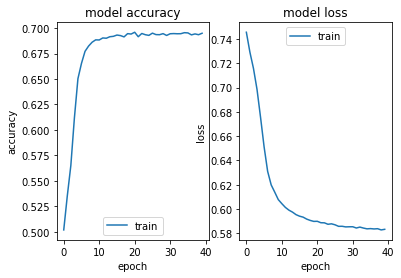

In [98]:
import matplotlib.pyplot as plt

print(result.history.keys())

history = result.history

fig, axs = plt.subplots(1, 2)

axs[0].plot(history['accuracy'])
axs[0].title.set_text('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='lower center')

axs[1].plot(history['loss'])
axs[1].title.set_text('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper center')

plt.show()